In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math

import plotly.graph_objects as go
import plotly.express as px
import numpy as np
import statsmodels.api as sm

In [2]:
datadir = '../data/'

In [3]:
def _read_file(fname, enc='iso8859-8'):
    fd = open(fname, encoding=enc, errors='replace')
    df = pd.read_csv(fd, sep='|')
    return df

def add_model(df):
    df['model'] = df.apply(lambda x: '_'.join([x[y] for y in ['tozeret_cd', 'degem_cd', 'shnat_yitzur', 'sug_degem']]), axis=1)

def get_model_name(ns):
    names = pd.DataFrame(data={'model':ns})
    ret = pd.merge(names, models, how='left', on='model')[['tozeret_nm', 'kinuy_mishari']]
    return ret

In [4]:
def convert_make(df, oldcol='tozeret_nm', newcol='make'):
    # read dictionary
    filename=datadir + 'makes_dict.csv'

    with open(filename, 'r') as f:
        lines = f.readlines()

    make_dict = []
    for line in lines:
        line = line.strip()
        items = line.split(',', 1)
        itm = items[0].strip()
        if len(items) > 1:
            make_dict.append((itm, items[1].strip()))
        else:
            make_dict.append((itm, itm))
    
    newdat = df[oldcol].copy()
    for (m_in, m_out) in make_dict:
        newdat[newdat.str.startswith(m_in)] = m_out
    df[newcol] = newdat

# in case we want to translate    
make_heb_to_eng= {
    'טסלה': 'Tesla',
    'BYD': 'BYD',
    'Geely': 'Geely',
    'יונדאי': 'Hyundai',
    'MG': 'MG',
    'Aiways': 'Aiways',
    'סקודה': 'Skoda',
    'מרצדס': 'Mercedes',
    'אאודי': 'Audi',
    'סרס': 'Seres',
    'סקיוול': 'Skywell',
    'קיה': 'Kia',
    'BMW': 'BMW',
    'פיאט': 'Fiat',
    'מקסוס': 'Lexus',
    'רנו': 'Renault',
    "פיג'ו": 'Peugeot',
    'GAC': 'GAC',
    'וולבו': 'Volvo',
    'טויוטה': 'Toyota',
    'סיטרואן': 'Citroën',
    'ניסאן': 'Nissan',
    'ליפמוטור': 'Lifan',
    'אורה': 'Ora',
    'פולקסווגן': 'Volkswagen',
    'אופל': 'Opel',
    'לקסוס': 'Lexus',
    'פורד': 'Ford',
    'פולסטאר': 'Polestar',
    'FAW': 'FAW',
    'פורשה': 'Porsche',
    'יגואר': 'Jaguar',
    'סמארט': 'Smart',
    'Voyah': 'Voyah',
    'LEVC': 'LEVC',
    'סיאט': 'Seat',
    'דאציה': 'Dacia',
    'DS': 'DS',
    'מזדה': 'Mazda',
    'שברולט': 'Chevrolet',
    'סנטרו סין': 'Centro China',
    'EVEASY': 'EVEASY',
    'מיצובישי': 'Mitsubishi',
    'גרייט וול': 'Great Wall'
}

In [5]:
def _convert_helper(df, oldcol, newcol, dictfile):
    # read dictionary
    filename=datadir + dictfile

    with open(filename, 'r') as f:
        lines = f.readlines()

    make_dict = []
    for line in lines:
        line = line.strip()
        items = line.split(',', 1)
        itm = items[0].strip()
        if len(items) > 1:
            make_dict.append((itm, items[1].strip()))
        else:
            make_dict.append((itm, itm))
    
    newdat = df[oldcol].copy()
    for (m_in, m_out) in make_dict:
        newdat[newdat.str.startswith(m_in)] = m_out
    df[newcol] = newdat
    
def convert_make(df, oldcol='tozeret_nm', newcol='make'):
    _convert_helper(df, oldcol, newcol, 'makes_dict.csv')

def convert_color(df, oldcol='tzeva_rechev', newcol='color'):
    _convert_helper(df, oldcol, newcol, 'color_dict.csv')

In [6]:
def trade_category(d):
    oc = d['ownership_count']
    months = d['months_to_first_trade']
    if math.isnan(oc):
        return 'ללא'
    if (oc == 1) & (months == 0):
        return 'מקורי'
    if months < 12:
        return 'נמכר תוך שנה'
    return 'נמכר תוך יותר משנה'

In [7]:
# source : https://data.gov.il/dataset/private-and-commercial-vehicles

#df = pd.read_csv('data/rechev-small.csv', encoding='iso-8859-1', sep='|')

def read_file(fname):
    fname = datadir + fname
    df = _read_file(fname)

    for c in ['mispar_rechev', 'degem_cd', 'tozeret_cd', 'shnat_yitzur']:
        df[c] = df[c].astype(str)

    df['test']= pd.to_datetime(df.mivchan_acharon_dt)
    df['test_expiry']= pd.to_datetime(df.tokef_dt)
    df['year'] = df['shnat_yitzur'].astype(int)
    c='moed_aliya_lakvish'
    df[c] = pd.to_datetime(df[c], format="%Y-%m")
    df['kvish_ym'] = df[c].dt.strftime('%Y%m')
    df['sidra'] = df['mispar_rechev'].apply(lambda k : k[-2:])
    add_model(df)
    convert_make(df)
    convert_color(df)
    return df

In [8]:
# the master file with all vehicles
df = read_file('rechev.csv')

In [9]:
# select the big makes
makes = df.groupby('make').size()
big_makes = makes[makes > 10000].index.tolist()

In [10]:
df_bak = df.copy()

In [11]:
df = df_bak.copy()

In [29]:
# add mileage data
# source: https://data.gov.il/dataset/shinui_mivne

mivne = _read_file(datadir + 'shinui_mivne.csv', enc='UTF-8')
for c in ['mispar_rechev']:
    mivne[c] = mivne[c].astype(str)

In [30]:
vo = pd.read_csv(datadir + 'vehicle_ownership.csv', sep='|')

c='mispar_rechev'
vo[c] = vo[c].astype(str)

c='baalut_dt'
vo[c] = pd.to_datetime(vo[c], format="%Y%m")

In [31]:
vo.baalut.value_counts()

פרטי     1619006
החכר      597239
סוחר      393190
חברה      141107
השכרה      38370
Name: baalut, dtype: int64

In [32]:
# count number of ownerships
oc = vo.groupby('mispar_rechev').size()
just1 = oc[oc == 1]
just1.name='ownership_count'
notjust1 = oc[~(oc == 1)]
notjust1.name='ownership_count_'

# The first ownership date is the purchase date. Pick the second-earliest date.
# This takes a long time, so we just do it for vehicles with at least two ownership dates.
mult_own = vo.merge(notjust1, how='right', left_on='mispar_rechev', right_index=True)

nownerships = mult_own.groupby('mispar_rechev').agg({'baalut_dt' : lambda x: x.nsmallest(2).iloc[-1], 'baalut' : 'count'})
nownerships.rename(columns={'baalut' : 'ownership_count'}, inplace=True)
nownerships.reset_index(inplace=True)

# add the vehicles with just one ownership date
single_own = vo.merge(just1, how='right', left_on='mispar_rechev', right_index=True).drop(columns=['baalut'])

nownerships = pd.concat([nownerships, single_own])

In [33]:
df = pd.merge(df, nownerships, on='mispar_rechev', how='left')

In [34]:
dfm = pd.merge(df, mivne, how='left', on='mispar_rechev')

In [35]:
from datetime import datetime

# days_on_road is the time from first mile till the last "test" - a date in which we know the vehicle was functional
# ownership_days is the time from first mile till today
now = datetime.now()
dfm['days_on_road'] = ((dfm['test'] - dfm['moed_aliya_lakvish']).dt.total_seconds())/(24*60*60)
dfm['ownership_days'] = ((now - dfm['moed_aliya_lakvish']).dt.total_seconds())/(24*60*60)

# remove what looks like bad data - over 0.5M km total
c='kilometer_test_aharon'
dfm[c] = dfm[c].clip(upper=500000)

dfm['avg_km_day'] = dfm[c] / dfm['days_on_road']

# remove what looks like bad data - over 1000 km per day (maybe the test date is keyed in wrong)
c='avg_km_day'
dfm[c] = dfm[c].clip(upper=1000)


In [36]:
#dfm[dfm['kilometer_test_aharon'] > 7e5][['tozeret_nm', 'kinuy_mishari', 'year', 'kilometer_test_aharon', 'baalut']]
#dfm[dfm['kilometer_test_aharon'] > 7e5]['make'].value_counts().to_dict()

In [37]:
# find the popular models
dfm['makemodel'] = dfm['make'] + ' ' + dfm['kinuy_mishari']
degem_c = dfm['makemodel'].value_counts()
degem_big = degem_c[degem_c > 5000].index.to_list()

In [21]:
mkm=dfm.query('makemodel in @degem_big')[['avg_km_day', 'makemodel']].groupby('makemodel').median()
mkm.sort_values(by='avg_km_day', ascending=False).head(50)

,avg_km_day
makemodel,
רנו FLUENCE,83.679916
רנו GRAND COUPE,77.159360
רנו KANGOO,74.056812
סקודה RAPID,69.572314
סקודה NEW OCTAVIA,67.531488
טויוטה AURIS HYBRID,67.219465
טויוטה PRIUS PLUS,66.356410
קיה CEED,62.835685
פולקסווגן JETTA,62.569800


In [22]:
ftkm = dfm.query('year == 2019')[['mispar_rechev', 'avg_km_day', 'sug_delek_nm']].dropna()
ftkm = ftkm[~np.isinf(ftkm['avg_km_day'])]
ftkm = ftkm[~ftkm['sug_delek_nm'].isnull()]

Text(0, 0.5, 'ימוי מ״ק עצוממ')

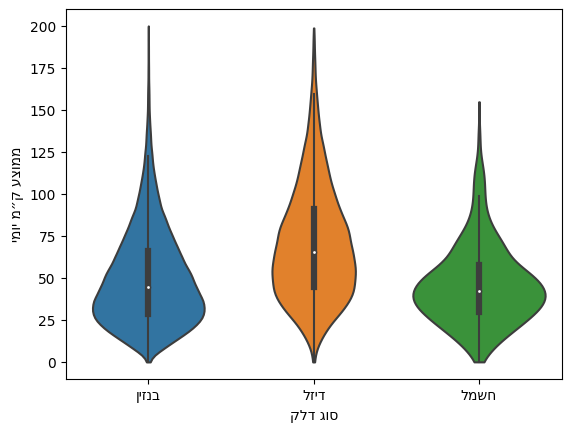

In [49]:
def rev(s):
    return s[::-1]

fueltypes = ['בנזין', 'דיזל', 'חשמל']
sns.violinplot(data=ftkm.query("avg_km_day < 200 and sug_delek_nm in @fueltypes"), x='sug_delek_nm', y='avg_km_day', cut=0)
# Get the xticklabels.
xticklabels = plt.gca().get_xticklabels()

# Reverse the label strings.
for i in range(len(xticklabels)):
    xticklabels[i] = rev(xticklabels[i].get_text())

# Set the new label strings.
plt.gca().set_xticklabels(xticklabels)
plt.xlabel(rev('סוג דלק'))
plt.ylabel(rev('ממוצע ק״מ יומי'))

In [46]:
mydf = ftkm.query("sug_delek_nm in @fueltypes")[['sug_delek_nm', 'avg_km_day']]
mydf.groupby('sug_delek_nm').mean()

,avg_km_day
sug_delek_nm,
בנזין,50.713008
דיזל,71.619079
חשמל,48.528818


In [111]:
import pandas as pd
import numpy as np

# Assuming you have a DataFrame named 'mydf' with columns 'sug_delek_nm' and 'avg_km_day'

# Step 1: Generate a vector of 100 even-spaced bins in the range of 'avg_km_day'
bin_edges = np.linspace(mydf['avg_km_day'].min(), mydf['avg_km_day'].max(), num=201)

# Step 2: Count the number of instances in each bin for each value of 'sug_delek_nm'
histogram = pd.crosstab(pd.cut(mydf['avg_km_day'], bins=bin_edges).apply(lambda x: x.left), mydf['sug_delek_nm'])

# Step 3: Normalize the counts so that each value of 'sug_delek_nm' sums to 1
normalized_histogram = histogram.div(histogram.sum(axis=0))

# Result: DataFrame with the lower edge of the bin as index and each value of 'sug_delek_nm' in a different column
result = normalized_histogram

# Display the result
result=result.rolling(window=5, min_periods=1, center=True).mean()
result.to_csv(datadir + 'avg_km_day_hist.csv')
#result.plot()

In [43]:
# restrict to vehicles from 2019, so they must have passed at least one "test"
agg_own = dfm.query('year == 2019')[['kilometer_test_aharon', 'ownership_count', 'make']].groupby('make').sum()
agg_own['avg_own_km'] = agg_own['kilometer_test_aharon'] / agg_own['ownership_count']
out=agg_own.query("ownership_count > 1000").sort_values(by='avg_own_km')
out[['avg_own_km']].to_csv(datadir + 'avg_km_owner_by_make.csv')
out

,kilometer_test_aharon,ownership_count,avg_own_km
make,,,
BMW,1.862844e+08,10150.0,18353.142167
מרצדס,1.515545e+08,7840.0,19330.930357
קאדילאק,2.098452e+07,1017.0,20633.746313
אופל,4.578808e+07,2035.0,22500.285995
אאודי,1.989180e+08,8347.0,23831.071043
רובר,4.674592e+07,1926.0,24270.985462
שברולט,3.158066e+08,11741.0,26897.759390
מזדה,5.875436e+08,21748.0,27015.981286
לקסוס,8.237460e+07,2951.0,27914.132497


In [44]:
agg_own = dfm.query('year == 2019 and makemodel in @degem_big')[['kilometer_test_aharon', 'ownership_count', 'makemodel']].groupby('makemodel').sum()
agg_own['avg_own_km'] = agg_own['kilometer_test_aharon'] / agg_own['ownership_count']
out = agg_own.query("ownership_count > 1000").sort_values(by='avg_own_km')
out[['avg_own_km']].to_csv(datadir + 'avg_km_owner_by_model.csv')
out

,kilometer_test_aharon,ownership_count,avg_own_km
makemodel,,,
מזדה MAZDA 2,128927113.0,5613.0,22969.376982
יונדאי TUCSON,366173010.0,15521.0,23592.101669
מיצובישי SPACE STAR,68290238.0,2881.0,23703.657758
שברולט SPARK,158682719.0,6562.0,24182.066291
יונדאי I10,402032513.0,16536.0,24312.561260
...,...,...,...
רנו GRAND COUPE,92698397.0,1862.0,49784.316327
טויוטה COROLLA TS HSD,163639844.0,3000.0,54546.614667
קיה CEED,75294967.0,1316.0,57215.020517


In [26]:
agg_own = dfm.query('year == 2019')[['kilometer_test_aharon', 'ownership_days', 'ownership_count', 'make']].groupby('make').sum()
agg_own['avg_km_day'] = agg_own['kilometer_test_aharon'] / agg_own['ownership_days']
agg_own['avg_km_owner'] = agg_own['kilometer_test_aharon'] / agg_own['ownership_count']
agg_own = agg_own.query("make in @big_makes")

In [27]:
agg_own.sort_values(by='avg_km_day', ascending=False)

,kilometer_test_aharon,ownership_days,ownership_count,avg_km_day,avg_km_owner
make,,,,,
רנו,7.820278e+08,1.286381e+07,16955.0,60.792863,46123.728871
דאציה,2.532590e+08,4.661368e+06,4844.0,54.331486,52283.040256
סקודה,1.461247e+09,2.820152e+07,33911.0,51.814470,43090.647784
סובארו,2.833698e+08,6.416531e+06,7103.0,44.162452,39894.377305
יונדאי,2.525227e+09,5.760853e+07,76832.0,43.834250,32866.859095
טויוטה,2.473132e+09,5.653837e+07,64884.0,43.742547,38116.212333
ניסאן,6.932800e+08,1.616256e+07,19720.0,42.894190,35156.184838
קרייזלר,7.629679e+07,1.789927e+06,2696.0,42.625637,28299.997404
קיה,1.916998e+09,4.512235e+07,56987.0,42.484435,33639.207907


In [28]:
agg_own.sort_values(by='avg_km_owner', ascending=False)

,kilometer_test_aharon,ownership_days,ownership_count,avg_km_day,avg_km_owner
make,,,,,
דאציה,2.532590e+08,4.661368e+06,4844.0,54.331486,52283.040256
רנו,7.820278e+08,1.286381e+07,16955.0,60.792863,46123.728871
סקודה,1.461247e+09,2.820152e+07,33911.0,51.814470,43090.647784
סובארו,2.833698e+08,6.416531e+06,7103.0,44.162452,39894.377305
סיטרואן,2.179906e+08,1.002099e+07,5581.0,21.753412,39059.418025
טויוטה,2.473132e+09,5.653837e+07,64884.0,43.742547,38116.212333
MG,6.049429e+07,1.591815e+06,1695.0,38.003335,35689.847198
ניסאן,6.932800e+08,1.616256e+07,19720.0,42.894190,35156.184838
סיאט,5.440694e+08,1.304090e+07,15899.0,41.720237,34220.354236


In [29]:
avg_own = dfm.query('year == 2019')[['kilometer_test_aharon', 'ownership_days', 'ownership_count', 'make']].groupby('make').mean()
avg_own = avg_own.query("make in @big_makes")

In [30]:
avg_own.sort_values(by='kilometer_test_aharon', ascending=False)

,kilometer_test_aharon,ownership_days,ownership_count
make,,,
רנו,97534.026316,1486.630039,2.091145
דאציה,85908.767639,1481.210023,1.616283
סקודה,85248.641094,1493.803855,1.959607
טויוטה,68458.515224,1467.385667,1.777011
יונדאי,65733.718190,1489.631673,1.988406
סובארו,65519.020116,1468.649895,1.629128
מיצובישי,65468.500791,1491.819488,1.997762
ניסאן,65323.656365,1493.077250,1.833225
סיטרואן,64647.275208,1472.375114,1.629489


In [64]:
out=avg_own.sort_values(by='ownership_count', ascending=False)
out['ownership_count'].to_csv(datadir + 'ownership_count.csv')
out

,kilometer_test_aharon,ownership_days,ownership_count
make,,,
מרצדס,56783.249906,1493.297985,2.851946
BMW,54469.120760,1465.315929,2.847924
אופל,52690.543153,1481.665331,2.289089
אאודי,55548.156939,1476.106694,2.256556
קרייזלר,64494.330516,1463.554655,2.206219
רנו,97534.026316,1486.630039,2.091145
מזדה,56299.689632,1497.966238,2.062595
שברולט,54970.686336,1496.433343,2.015622
מיצובישי,65468.500791,1491.819488,1.997762


In [32]:
topN = 15
top_colors = df.groupby('color').size().nlargest(topN).index
#color_counts = color_counts[color_counts['color'].isin(top_colors)]
top_colors

Index(['לבן', 'כסף', 'אפור', 'שחור', 'כחול', 'בז', 'אדום', 'תכלת', ' לא ידוע',
       'ירוק', 'חום', 'ברונזה', 'זהב', 'כתום', 'קרם'],
      dtype='object', name='color')

In [33]:
avg_color = dfm.query('year == 2019 and color in @top_colors')[['kilometer_test_aharon', 'ownership_days', 'ownership_count', 'color']].groupby('color').mean()

In [34]:
avg_color.sort_values(by='ownership_count', ascending=False)

,kilometer_test_aharon,ownership_days,ownership_count
color,,,
שחור,63678.233989,1484.549862,2.111372
קרם,51477.404651,1491.287965,1.963218
לבן,67969.970219,1481.258335,1.921127
אפור,65390.714678,1483.282904,1.879213
חום,76422.018409,1509.100564,1.863046
כסף,66856.204080,1480.269468,1.861530
בז,61644.532172,1505.909904,1.853059
זהב,46476.177215,1505.307302,1.775000
כחול,55450.005709,1482.046801,1.729834


In [35]:
avg_color.sort_values(by='kilometer_test_aharon', ascending=False)

,kilometer_test_aharon,ownership_days,ownership_count
color,,,
חום,76422.018409,1509.100564,1.863046
לבן,67969.970219,1481.258335,1.921127
כסף,66856.204080,1480.269468,1.861530
אפור,65390.714678,1483.282904,1.879213
שחור,63678.233989,1484.549862,2.111372
בז,61644.532172,1505.909904,1.853059
כתום,60346.394937,1486.637449,1.651685
תכלת,60167.077106,1447.393155,1.626177
כחול,55450.005709,1482.046801,1.729834


In [36]:
avg_own = dfm.query('year == 2019')[['kilometer_test_aharon', 'ownership_days', 'ownership_count', 'make']].groupby('make').mean()
avg_own = avg_own.query("make in @big_makes")

In [37]:
# read detailed tech specs on each model
# source: https://data.gov.il/dataset/degem-rechev-wltp
models = _read_file(datadir + 'models.csv', enc='utf-8')
cols = ['tozeret_cd', 'tozeret_nm', 'shnat_yitzur',
       'degem_cd', 'nefah_manoa',
       'mishkal_kolel', 'gova',
       'hege_koah_ind',
       'automatic_ind',
       'koah_sus',
       'mispar_moshavim', 'kinuy_mishari', 'sug_degem',
       'hanaa_nm', 'merkav'
       ]
models = models[cols]
for c in ['degem_cd', 'tozeret_cd', 'shnat_yitzur']:
    models[c] = models[c].astype(str)

add_model(models)
models_ = models.copy()

In [38]:
models = models_.copy()
models = models[['model', 'mishkal_kolel', 'gova', 'koah_sus', 'nefah_manoa']]

In [39]:
# source : https://data.gov.il/dataset/mehir_yevuan
# add model prices
fname = datadir + 'vehicle_cost.csv'
fd = open(fname, encoding='utf-8', errors='replace')
prices = pd.read_csv(fd, sep='|', low_memory=False)

for c in ['degem_cd', 'tozeret_cd', 'shnat_yitzur']:
    prices[c] = prices[c].astype(str)
for c in ['mehir']:
    prices[c] = pd.to_numeric(prices[c], errors='coerce')

add_model(prices)
prices_ = prices.copy()
prices = prices[['model', 'mehir']]

In [40]:
baalut_list = ['ליסינג', 'פרטי']
dfm_models = pd.merge(left=dfm, right=models, on='model')
dfm_models = dfm_models.merge(right=prices, on='model')

In [41]:
dfm_models = dfm_modles.copy()

NameError: name 'dfm_modles' is not defined

In [ ]:
tcol = 'avg_km_day'
features = ['mishkal_kolel', 'gova', 'koah_sus', 'nefah_manoa', 'mehir']
avg_model = dfm_models.query('year >= 2018 and year < 2021 and baalut in @baalut_list')[[tcol, 'makemodel', 'baalut'] + features]
grouped_df = avg_model.groupby(['makemodel', 'baalut']).agg({'baalut': 'size', tcol: 'mean'})
grouped_df = grouped_df.query("baalut > 30").drop(columns="baalut")
avg_model_r = grouped_df.reset_index()

In [ ]:
model_features = avg_model[features + ['makemodel']].groupby('makemodel').mean()

In [ ]:
avg_model = avg_model_r.pivot(index='makemodel', columns='baalut').dropna()

avg_model.columns = avg_model.columns.droplevel(0)

avg_model.rename_axis(None, axis=1, inplace=True)
avg_model.reset_index(inplace=True)

In [ ]:
avg_model = avg_model.merge(model_features, how='left', on='makemodel')

In [ ]:
def rel_diff(a, b):
    return (a-b)/a

avg_model['diff'] = avg_model.apply(lambda r : rel_diff(r['ליסינג'], r['פרטי']), axis=1)

In [ ]:
import plotly.express as px

fig = px.scatter(avg_model, x='diff', y='mehir', hover_data=['makemodel'], title='Scatter Plot')
fig.show()

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio

def create_scatterplots(df, features, filename=None):
    # Create subplots
    fig = make_subplots(rows=len(features), cols=1, shared_xaxes=True)

    # Iterate over features
    for i, feature in enumerate(features, start=1):
        # Add scatterplot to each subplot
        fig.add_trace(go.Scatter(
            x=df['diff'],
            y=df[feature],
            mode='markers',
            name=feature,
            text=df['makemodel'],
            hovertemplate="Diff: %{x}<br>" + feature + ": %{y}<br>Makemodel: %{text}"
        ), row=i, col=1)

    # Update layout
    fig.update_layout(height=1200, width=800, title_text="Scatterplots")

    # Show the figure
    fig.show()
    if filename is not None:
        pio.write_html(fig, file=filename)

In [ ]:
create_scatterplots(avg_model, features, 'chart.html')

In [ ]:

fig = px.scatter(avg_model, x='diff', y='mishkal_kolel', hover_data=['makemodel'], title='Scatter Plot')
fig.show()
